# Introduction to Rapids

![Rapids](../nb_images/rapids.png)
<img src="../nb_images/rapids.png" alt="Drawing" style="width: 200px;"/>


Rapids is a data preparation and machine learning library that is designed to take maximum advantage of the Nvidia GPU.  The libraries are called cuDF and cuML and take a lot of the same design and API semantics from Pandas and Sklearn Python libaries.   Speedups of over 10x are not uncommon for a lot of everyday tasks.

If you are familiar with Pandas and Sklearn, this code in this lab will look familiar.  Rapids is still under development, so its not as full featured as the Pandas and Sklearn libraries, but it is continually getting new functions.  

The following lab will walk you through how to use Rapids with a sample dataset.  **This lab will focus on the performance capabilities of Rapids by comparing it to Pandas and Sklearn equivalent operations.** It is not meant to be a machine learning tutorial. 


## CuDF basics

Built based on the Apache Arrow columnar memory format, cuDF is a GPU DataFrame library for loading, joining, aggregating, filtering, and otherwise manipulating data.

cuDF provides a pandas-like API that will be familiar to data engineers & data scientists, so they can use it to easily accelerate their workflows without going into the details of CUDA programming.


### Helper functions

In [4]:
# [print gpu dataframe] helper function to print GPU dataframes 
def pgdf(gdf) :
    display(gdf.to_pandas())

In [5]:
def time_command(cmd,repeat=1) :
    avg_runtime = timeit.timeit(cmd, number=repeat)
    return float(avg_runtime / repeat)

In [6]:
# Dictionary to store results ..
# example "describe" : {"gpu" : []}
class COMPARE() :
        ## Abstract Custom Implementations
    def __init__(self) :
        #nprint("Loading Data.  Overriding __init__ from dfutils")
        self.tests = []
        self.gpu_results = {}
        self.cpu_results = {}

    def add_result(self, test_name, gpu_result, runtime) :
        if test_name not in self.tests :
            self.tests.append(test_name)
            self.gpu_results[test_name] = []
            self.cpu_results[test_name] = []
        
        if(gpu_result == "gpu") :
            self.gpu_results[test_name].append(runtime)
        else :
            self.cpu_results[test_name].append(runtime)
            
    def display_results(self) :
        print("{:<20} {:<20} {:<20} {:<20}".format("test", "CPU(s)", "GPU(s)", "GPU Speedup"))
        for i in self.tests :
            cpu_mean = sum(self.cpu_results[i]) / (len(self.cpu_results[i])+0.00001)
            gpu_mean = sum(self.gpu_results[i]) / (len(self.gpu_results[i])+0.00001)
            su = cpu_mean / (gpu_mean + .00001)
            print("{:<20} {:<20.4f} {:<20.4f} {:<20.2f}".format(i, cpu_mean, gpu_mean, su ))

run_times = COMPARE()


In [7]:
# Imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import time
import timeit

from datetime import datetime
import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import glob
import os
import sys
sys.path.append('../utils/') 

#dask
import dask
from dask import dataframe as dd

# Rapids
import cudf
from cudf.dataframe import DataFrame as RapidsDataFrame

In [53]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def pca_scree(pca_explained_variance, label) :
        
    # bin is my x axis variable
    bin = []
    for i in range (len(pca_explained_variance)):
        bin.append(i+1)
    # plot the cummulative variance against the index of PCA
    cum_var = np.cumsum(pca_explained_variance)
    plt.plot(bin, cum_var)
    # plot the 95% threshold, so we can read off count of principal components that matter
    plt.plot(bin, [.95]*n_components, '--')
    plt.plot(bin, [.75]*n_components, '--')
    plt.plot(bin, [.50]*n_components, '--')
    #turn on grid to make graph reading easier
    plt.grid(True)
    #plt.rcParams.update({'font.size': 24})
    plt.suptitle(label + ' PCA Variance Explained')
    plt.xlabel('Number of PCA Components', fontsize=18)
    plt.ylabel('Fraction of Variance \nExplained', fontsize=16)
    # control number of tick marks, 
    plt.xticks([i for i in range(0,n_components)])
    plt.show()


### Useful DataFrame attributes

When you create a GPU dataframe, there are a number of methods available for you to understand the composition.  The detailed list is found in the Rapids [cuDF documentation](https://docs.rapids.ai/api/cudf/0.7/) 

Below we will create a dummy dataframe and look at some of its attributes.

In [8]:
# Create a simple GPU dataframe
df = cudf.DataFrame()
df['column1'] = [0, 1, 2, 3, 4]
df['column2'] = [float(i + 10) for i in range(5)]  # insert column
df['column3'] = ["bbb","aaa","ccc","eee","Ddd"]  # insert column

In [9]:
#Print the dataframe
pgdf(df)

,column1,column2,column3
0,0,10.0,bbb
1,1,11.0,aaa
2,2,12.0,ccc
3,3,13.0,eee
4,4,14.0,Ddd


In [10]:
# Dataframe attributes
print("\nDataframe datatypes\n---------------------")
print(df.dtypes)
print("\nDataframe Shape\n---------------------")
print(df.shape)
print("\nDataframe dimesions\n---------------------")
print(df.ndim)
print("\nDataframe Column names\n---------------------")
print(df.columns)


Dataframe datatypes
---------------------
column1      int64
column2    float64
column3     object
dtype: object

Dataframe Shape
---------------------
(5, 3)

Dataframe dimesions
---------------------
2

Dataframe Column names
---------------------
Index(['column1', 'column2', 'column3'], dtype='object')


In [11]:
### Dataframe Operations : Create random large array
a = np.random.rand(1000,1000)
df = cudf.DataFrame()
df = df.from_records(a)
#df['random_column1'] = [0, 1, 2, 3, 4]
pgdf(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.296762,0.664909,0.693043,0.475366,0.927600,0.806723,0.884779,0.294128,0.507124,0.263270,0.558447,0.457083,0.901011,0.828568,0.802974,0.748373,0.760884,0.635217,0.836958,0.898571,0.350539,0.370187,0.214325,0.190259,0.849708,0.125653,0.467415,0.451634,0.102716,0.827131,0.913811,0.093909,0.311650,0.266523,0.287728,0.294492,0.952833,0.147202,0.780774,0.688131,0.134289,0.288885,0.094080,0.025312,0.290469,0.293879,0.628554,0.533279,0.990645,0.255365,0.323361,0.070546,0.809356,0.637576,0.810990,0.716727,0.978838,0.231316,0.191970,0.836167,0.124738,0.558420,0.380265,0.121535,0.926986,0.726008,0.136605,0.810283,0.662398,0.374361,0.616704,0.729925,0.024961,0.610107,0.017467,0.423216,0.191762,0.592537,0.141283,0.461231,0.421199,0.934359,0.501099,0.540643,0.017177,0.994447,0.632900,0.977522,0.678462,0.642141,0.766857,0.468119,0.650398,0.097779,0.702207,0.078216,0.053698,0.061613,0.064651,0.786659,0.286234,0.405984,0.563196,0.764301,0.984131,0.608932,0.699879,0.400873,0.231089,0.567675,0.736241,0.138943,0.519319,0.320489,0.219696,0.868046,0.800624,0.957297,0.406311,0.922674,0.895779,0.639839,0.810020,0.392728,0.257733,0.564589,0.732316,0.814164,0.568027,0.818223,0.685378,0.382050,0.764500,0.292078,0.521530,0.291283,0.276236,0.758599,0.427656,0.662902,0.256876,0.255581,0.184569,0.423002,0.928211,0.684219,0.309984,0.718945,0.130411,0.355924,0.723339,0.893404,0.303679,0.806013,0.684644,0.426939,0.131476,0.977692,0.399147,0.314568,0.991222,0.561632,0.052239,0.431272,0.570403,0.401978,0.105343,0.468157,0.088370,0.773252,0.783034,0.328149,0.790541,0.526385,0.610259,0.488078,0.500878,0.218834,0.439182,0.060201,0.410185,0.284858,0.115772,0.137044,0.298143,0.991888,0.764361,0.187406,0.266647,0.964830,0.472051,0.265925,0.038771,0.785477,0.041250,0.780222,0.341667,0.373806,0.384904,0.184724,0.904385,0.352736,0.054172,0.333162,0.206603,0.741069,0.818538,0.359597,0.555447,0.575318,0.680629,0.203544,0.634268,0.526581,0.890550,0.902908,0.396290,0.940004,0.969685,0.118319,0.445468,0.743104,0.042058,0.649990,0.716590,0.505744,0.239516,0.995577,0.613812,0.359186,0.565972,0.986815,0.323230,0.7353

### Dataframe Operations : Slice  Example - grab 10 rows and 10 columns

In [12]:
pgdf(df.iloc[200:210,100:120] )

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999


In [13]:
### Dataframe Operations : Slice  Example - grab 10 columsn

## CuML basics

CuML is the a machine learning library implemented on the Nvidia GPU.  This allows you to use many of the most common machine learning algorithms without having to write CUDA code.  The list of algorithms is growing with each release so its worth taking a look at the cuML github repo, but in general you can expect a 10x to 50x performance speedup when using the GPU enabled algorithm.  Later in this lab we will see examples of PCA and linear regression.

## Dask

Dask is an extremely useful python library that enables parallel execution of arbitrary python programs allowing you to make maximum use of system resources.  It is typically used for libraries that are written in single threaded implementation like pandas and numpy, but its also very useful for running many a parallel tasks when using Rapids.  We will have an example to demonstrate this at the end of the lab.

# Lab Use Case 

**The main goal of this lab is to focus on the performance differences of Rapids(GPU) vs Pandas/Sklearn (CPU) implemenations.**  

To do this we will use the Lending Club publicly available dataset. ![lendingclub](../nb_images/lendingclub.png) This data set is published by lending club and contains information regarding prospective loan applicants.  

As we go through the lab, we will show the similarity in the syntax/usage of the library using this real world dataset and keep track of the runtimes in a comparison report.



## Lending Club data and Lab Details

In [14]:
# a = timeit.timeit('"-".join(str(n) for n in range(100))', number=1)
# run_times.add_result("test", "gpu", a)
# run_times.display_results()
# 
# b = timeit.timeit('"-".join(str(n) for n in range(100))', number=100)
# run_times.add_result("test", "cpu", b)
# a = timeit.timeit('"-".join(str(n) for n in range(100))', number=1)
# run_times.add_result("test", "gpu", a)
# b = timeit.timeit('"-".join(str(n) for n in range(100))', number=100)
# run_times.add_result("test", "cpu", b)
# a = timeit.timeit('"-".join(str(n) for n in range(100))', number=1)
# run_times.add_result("test1", "gpu", a)
# b = timeit.timeit('"-".join(str(n) for n in range(100))', number=100)
# run_times.add_result("test1", "cpu", b)
# 
# run_times.display_results()

# Data Preparation using cuDF

Here we will load in the lendinclub dataset and perform some basic data preparation steps.  We will keep track of the 


- [x] remove this
- [ ] keepthis

lessons learned ... data MUST be clean prior to descibe functions.  Errors encountered 
- duplicate index caused error (this was due to concatenating dataframes)
- NaN causes KeyError messages.  Columns must be clean !
- Pandas takes care of these automatically ....


## Load the Lending Club Data

Here we will load the data twice.  Once into a pandas dataframe **loan_pdf** and once into a rapids dataframe **loan_rdf**.  

In [15]:
# import data
filename = "../dataprep_common/loan_project_df.parquet.gzip"
DATA_DOUBLE_FACTOR=3

# Pandas dataframe
loan_pdf = pd.read_parquet(filename)#  , names=ts_cols,dtype=ts_dtypes,skiprows=1)

# Rapids Dataframe
loan_rdf = cudf.read_parquet(filename)#  , names=ts_cols,dtype=ts_dtypes,skiprows=1)

In [16]:
# Scale up data to 40 million rows
for i in range(DATA_DOUBLE_FACTOR) :
    loan_pdf = pd.concat([loan_pdf,loan_pdf],axis=0)
    loan_rdf = cudf.concat([loan_rdf,loan_rdf],axis=0)
    loan_rdf = loan_rdf.reset_index().drop("index",axis=1)
    loan_pdf = loan_pdf.reset_index().drop("index",axis=1)
    #pgdf(loan_rdf.head())
    #display(loan_pdf.head())
    

In [17]:
# Dataframe attributes
print("Rapids")
print("\nDataframe datatypes\n---------------------")
print(loan_rdf.dtypes)
print("\nDataframe Shape (rows,cols)\n---------------------")
print(loan_rdf.shape)
print("\nDataframe dimesions\n---------------------")
print(loan_rdf.ndim)
print("\nDataframe Column names\n---------------------")
print(loan_rdf.columns)

# Dataframe attributes
print("\n\nPandas")
print("\nDataframe datatypes\n---------------------")
print(loan_pdf.dtypes)
print("\nDataframe Shape (rows,cols)\n---------------------")
print(loan_pdf.shape)
print("\nDataframe dimesions\n---------------------")
print(loan_pdf.ndim)
print("\nDataframe Column names\n---------------------")
print(loan_pdf.columns)

Rapids

Dataframe datatypes
---------------------
loan_amnt                  float64
annual_inc                 float64
dti                        float64
fico_range_high            float64
open_acc                   float64
funded_amnt                float64
total_acc                  float64
grade                       object
default                      int64
issue_d             datetime64[ms]
earliest_cr_line    datetime64[ms]
addr_state                  object
dtype: object

Dataframe Shape (rows,cols)
---------------------
(10224344, 12)

Dataframe dimesions
---------------------
2

Dataframe Column names
---------------------
Index(['loan_amnt', 'annual_inc', 'dti', 'fico_range_high', 'open_acc', 'funded_amnt', 'total_acc', 'grade', 'default', 'issue_d', 'earliest_cr_line', 'addr_state'], dtype='object')


Pandas

Dataframe datatypes
---------------------
loan_amnt                  float64
annual_inc                 float64
dti                        float64
fico_range_high     

In [18]:
pgdf(loan_rdf)

,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,grade,default,issue_d,earliest_cr_line,addr_state
0,2500.0,53700.00,28.56,779.0,20.0,2500.0,38.0,A,0,2018-03-01,2001-11-01,PA
1,25000.0,40000.00,27.78,729.0,8.0,25000.0,16.0,C,0,2018-03-01,2003-03-01,OR
2,20000.0,19000.00,45.17,799.0,6.0,20000.0,9.0,B,0,2018-03-01,1987-10-01,FL
3,30000.0,51500.00,9.93,669.0,7.0,30000.0,9.0,C,0,2018-03-01,2011-03-01,FL
4,15000.0,195000.00,21.10,679.0,18.0,15000.0,34.0,C,0,2018-03-01,2000-10-01,FL
5,12000.0,240000.00,10.99,729.0,14.0,12000.0,23.0,A,0,2018-03-01,1990-01-01,CT
6,7000.0,180700.00,18.98,714.0,13.0,7000.0,17.0,A,0,2018-03-01,2004-06-01,IL
7,34000.0,105000.00,20.16,714.0,18.0,34000.0,22.0,B,0,2018-03-01,2007-04-01,HI
8,5000.0,36610.00,13.85,769.0,15.0,5000.0,20.0,A,0,2018-03-01,2005-09-01,NJ
9,26000.0,33000.00,20.05,709.0,9.0,26000.0,21.0,B,0,2018-03-01,1994-02-01,IL


## [Debug only] : Count NaN per column

In [19]:
# NaN report
def nan_report(df) :
    for c in df.columns :
        print("{} {}".format(c, df[c].null_count))

nan_report(loan_rdf)

loan_amnt 0
annual_inc 0
dti 0
fico_range_high 0
open_acc 0
funded_amnt 0
total_acc 0
grade 0
default 0
issue_d 0
earliest_cr_line 0
addr_state 0


## Descriptive Statistics - Describe Performance comparison

The first comparison we will make is using the describe function.  Describe is useful because it looks at all the descriptive statistics of the dataset.  It calculates mean/standard deviation/medain statistics for all the numerical columns.  If you have a large dataframe it can take some time to calculate.  Lets see how Rapids performs  with this dataset.

In [20]:
# CPU / pandas
loan_pdf.describe()

,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,default
count,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07
mean,1.550027e+04,8.037944e+04,1.944029e+01,7.061987e+02,1.164129e+01,1.550025e+04,2.335774e+01,4.722298e-02
std,9.750741e+03,1.405961e+05,1.778771e+01,3.472743e+01,5.863428e+00,9.750743e+03,1.206642e+01,2.121155e-01
min,1.000000e+03,0.000000e+00,-1.000000e+00,6.640000e+02,0.000000e+00,1.000000e+03,2.000000e+00,0.000000e+00
25%,8.000000e+03,4.700000e+04,1.183000e+01,6.790000e+02,8.000000e+00,8.000000e+03,1.500000e+01,0.000000e+00
50%,1.300000e+04,6.684000e+04,1.797000e+01,6.990000e+02,1.100000e+01,1.300000e+04,2.100000e+01,0.000000e+00
75%,2.050000e+04,9.600000e+04,2.501000e+01,7.240000e+02,1.500000e+01,2.050000e+04,3.000000e+01,0.000000e+00
max,4.000000e+04,1.100000e+08,9.990000e+02,8.500000e+02,1.010000e+02,4.000000e+04,1.760000e+02,1.000000e+00


In [21]:
# GPU / Rapids
pgdf(loan_rdf.describe())

,stats,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,default
0,count,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07,1.022434e+07
1,mean,1.550027e+04,8.037944e+04,1.944029e+01,7.061987e+02,1.164129e+01,1.550025e+04,2.335774e+01,4.722300e-02
2,std,9.750741e+03,1.405961e+05,1.778771e+01,3.472743e+01,5.863428e+00,9.750743e+03,1.206642e+01,2.121150e-01
3,min,1.000000e+03,0.000000e+00,-1.000000e+00,6.640000e+02,0.000000e+00,1.000000e+03,2.000000e+00,0.000000e+00
4,25%,8.000000e+03,4.700000e+04,1.183000e+01,6.790000e+02,8.000000e+00,8.000000e+03,1.500000e+01,0.000000e+00
5,50%,1.300000e+04,6.684000e+04,1.797000e+01,6.990000e+02,1.100000e+01,1.300000e+04,2.100000e+01,0.000000e+00
6,75%,2.050000e+04,9.600000e+04,2.501000e+01,7.240000e+02,1.500000e+01,2.050000e+04,3.000000e+01,0.000000e+00
7,max,4.000000e+04,1.100000e+08,9.990000e+02,8.500000e+02,1.010000e+02,4.000000e+04,1.760000e+02,1.000000e+00


In [22]:
# Record results
def describe_gpu():
    loan_rdf.describe()

def describe_cpu():
    loan_pdf.describe()

#display(loan_rdf.describe().to_pandas())

run_times.add_result("describe", "gpu", time_command(describe_gpu))
run_times.add_result("describe", "cpu", time_command(describe_cpu))

run_times.display_results()

test                 CPU(s)               GPU(s)               GPU Speedup         
describe             4.9802               0.2724               18.29               


## One Hot Encoding (OHE) Performance Comparison

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

Currently, one hot endcoding for Rapids requires the column that is to be encoded to be an integer or float, not a string.  You will need to create an integer column prior to using this!  You can use the hash_encode method to accomplish this, although you lose a little bit of readability.

In [23]:
# CPU / pandas example
ohe_cpu_df = pd.get_dummies(loan_pdf['grade'])

In [24]:
# GPU / Rapids example
# cudf 0.9 cudf.reshape.general.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, cats={}, sparse=False, drop_first=False, dtype='int8')

MAX_VAL=7
loan_rdf['grade_hash'] = loan_rdf['grade'].hash_encode(stop=MAX_VAL)
ohe_gpu_df = loan_rdf.one_hot_encoding(column='grade_hash', prefix='grade_ohe_', cats=list(range(MAX_VAL)))


In [25]:
# Compare the results
display(ohe_cpu_df.head())
pgdf(ohe_gpu_df.head())

,A,B,C,D,E,F,G
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,grade,default,issue_d,earliest_cr_line,addr_state,grade_hash,grade_ohe__0,grade_ohe__1,grade_ohe__2,grade_ohe__3,grade_ohe__4,grade_ohe__5,grade_ohe__6
0,2500.0,53700.0,28.56,779.0,20.0,2500.0,38.0,A,0,2018-03-01,2001-11-01,PA,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,25000.0,40000.0,27.78,729.0,8.0,25000.0,16.0,C,0,2018-03-01,2003-03-01,OR,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,20000.0,19000.0,45.17,799.0,6.0,20000.0,9.0,B,0,2018-03-01,1987-10-01,FL,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30000.0,51500.0,9.93,669.0,7.0,30000.0,9.0,C,0,2018-03-01,2011-03-01,FL,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,15000.0,195000.0,21.10,679.0,18.0,15000.0,34.0,C,0,2018-03-01,2000-10-01,FL,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Record the results

def ohe_cpu() :
    pd.get_dummies(loan_pdf['grade'])

def ohe_gpu() :
    MAX_VAL=10
    loan_rdf['grade_hash'] = loan_rdf['grade'].hash_encode(stop=MAX_VAL)
    loan_rdf.one_hot_encoding(column='grade_hash', prefix='grade_ohe_', cats=list(range(MAX_VAL)))

#print(loan_rdf.columns)
#ohe_gpu()
#print(loan_rdf2.columns)

#display(loan_rdf.one_hot_encoding(column='grade_hash', prefix='grade_ohe_', cats=list(range(MAX_VAL))).to_pandas() )
#print(loan_rdf['grade'])
#print()

run_times.add_result("one_hot_encode", "cpu", time_command(ohe_cpu))
run_times.add_result("one_hot_encode", "gpu", time_command(ohe_gpu))
run_times.display_results()


test                 CPU(s)               GPU(s)               GPU Speedup         
describe             4.9802               0.2724               18.29               
one_hot_encode       0.8645               0.0778               11.11               


## Filter with Date and Time ops - Performance comparison

Current datetime functionality is limited to filtering data set for specific times.  Doesn't not yet support math operations.

Here we will find loan applicants that have a credit line prior to 2010.

In [27]:
import datetime as dt

search_date = dt.datetime.strptime('2010-01-01', '%Y-%m-%d')

In [28]:
# CPU / pandas
query_cpu=loan_pdf.query('earliest_cr_line <= @search_date')


In [29]:
# GPU / Rapids
query_gpu=loan_rdf.query('earliest_cr_line <= @search_date')


In [30]:
# compare results
display(query_cpu.head())
pgdf(query_gpu.head())

,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,grade,default,issue_d,earliest_cr_line,addr_state
0,2500.0,53700.0,28.56,779.0,20.0,2500.0,38.0,A,0,2018-03-01,2001-11-01,PA
1,25000.0,40000.0,27.78,729.0,8.0,25000.0,16.0,C,0,2018-03-01,2003-03-01,OR
2,20000.0,19000.0,45.17,799.0,6.0,20000.0,9.0,B,0,2018-03-01,1987-10-01,FL
4,15000.0,195000.0,21.10,679.0,18.0,15000.0,34.0,C,0,2018-03-01,2000-10-01,FL
5,12000.0,240000.0,10.99,729.0,14.0,12000.0,23.0,A,0,2018-03-01,1990-01-01,CT


,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,grade,default,issue_d,earliest_cr_line,addr_state,grade_hash
0,2500.0,53700.0,28.56,779.0,20.0,2500.0,38.0,A,0,2018-03-01,2001-11-01,PA,7
1,25000.0,40000.0,27.78,729.0,8.0,25000.0,16.0,C,0,2018-03-01,2003-03-01,OR,6
2,20000.0,19000.0,45.17,799.0,6.0,20000.0,9.0,B,0,2018-03-01,1987-10-01,FL,5
4,15000.0,195000.0,21.10,679.0,18.0,15000.0,34.0,C,0,2018-03-01,2000-10-01,FL,6
5,12000.0,240000.0,10.99,729.0,14.0,12000.0,23.0,A,0,2018-03-01,1990-01-01,CT,7


In [31]:
# Filter Record results
def filter_cpu():
    loan_pdf.query('earliest_cr_line <= @search_date')
    
def filter_gpu():
    loan_rdf.query('earliest_cr_line <= @search_date')
    
run_times.add_result("filter_dt", "cpu", time_command(filter_cpu,repeat=3))
run_times.add_result("filter_dt", "gpu", time_command(filter_gpu,repeat=3))
run_times.display_results()


test                 CPU(s)               GPU(s)               GPU Speedup         
describe             4.9802               0.2724               18.29               
one_hot_encode       0.8645               0.0778               11.11               
filter_dt            0.6366               0.4096               1.55                


## Sort by value

In [32]:
# CPU / pandas
sort_cpu=loan_pdf.sort_values(by='fico_range_high')

In [33]:
# GPU / Rapids
sort_gpu=loan_rdf.sort_values(by='fico_range_high')

In [34]:
# compare results
display(query_cpu.head())
pgdf(query_gpu.head())

,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,grade,default,issue_d,earliest_cr_line,addr_state
0,2500.0,53700.0,28.56,779.0,20.0,2500.0,38.0,A,0,2018-03-01,2001-11-01,PA
1,25000.0,40000.0,27.78,729.0,8.0,25000.0,16.0,C,0,2018-03-01,2003-03-01,OR
2,20000.0,19000.0,45.17,799.0,6.0,20000.0,9.0,B,0,2018-03-01,1987-10-01,FL
4,15000.0,195000.0,21.10,679.0,18.0,15000.0,34.0,C,0,2018-03-01,2000-10-01,FL
5,12000.0,240000.0,10.99,729.0,14.0,12000.0,23.0,A,0,2018-03-01,1990-01-01,CT


,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,grade,default,issue_d,earliest_cr_line,addr_state,grade_hash
0,2500.0,53700.0,28.56,779.0,20.0,2500.0,38.0,A,0,2018-03-01,2001-11-01,PA,7
1,25000.0,40000.0,27.78,729.0,8.0,25000.0,16.0,C,0,2018-03-01,2003-03-01,OR,6
2,20000.0,19000.0,45.17,799.0,6.0,20000.0,9.0,B,0,2018-03-01,1987-10-01,FL,5
4,15000.0,195000.0,21.10,679.0,18.0,15000.0,34.0,C,0,2018-03-01,2000-10-01,FL,6
5,12000.0,240000.0,10.99,729.0,14.0,12000.0,23.0,A,0,2018-03-01,1990-01-01,CT,7


In [35]:
# Sorting Record results
def sort_cpu():
    loan_pdf.sort_values(by='fico_range_high')
    
def sort_gpu():
    loan_rdf.sort_values(by='fico_range_high')
    
run_times.add_result("sorting", "cpu", time_command(sort_cpu))
run_times.add_result("sorting", "gpu", time_command(sort_gpu))
run_times.display_results()


test                 CPU(s)               GPU(s)               GPU Speedup         
describe             4.9802               0.2724               18.29               
one_hot_encode       0.8645               0.0778               11.11               
filter_dt            0.6366               0.4096               1.55                
sorting              3.2606               0.2894               11.27               


## Histograms and Custom functions

Here we demonstrate how fast Rapids is at creating histogram bins.  We use the loan_amount column with a custom function to create a loan_bins column.  Then we grab the value counts using both Pandas and Rapids to get a rough comparison of the speed of these types of operations.


In [36]:
# custom function example : creates simple bins for loan_amount histogram
def roundto(num):
    roundto=5000
    a = int(num / roundto)
    return float(a*roundto) 


In [37]:
# CPU / pandas

loan_pdf['loan_bins'] = loan_pdf.loan_amnt.apply(roundto)
loan_pdf['loan_bins'].value_counts()


10000.0    2339192
5000.0     2143096
15000.0    1521720
20000.0    1299760
0.0         980440
25000.0     649800
30000.0     542544
35000.0     457144
40000.0     290648
Name: loan_bins, dtype: int64

In [38]:
# GPU / rapids
loan_rdf['loan_bins'] = loan_rdf.loan_amnt.applymap(roundto)
print(loan_rdf['loan_bins'].value_counts())



10000.0    2339192
5000.0    2143096
15000.0    1521720
20000.0    1299760
0.0     980440
25000.0     649800
30000.0     542544
35000.0     457144
40000.0     290648
dtype: int64


In [39]:
# Record the results
def hist_cpu() :
    loan_pdf['loan_bins'] = loan_pdf.loan_amnt.apply(roundto)
    loan_pdf['loan_bins'].value_counts()

def hist_gpu() :
    loan_rdf['loan_bins'] = loan_rdf.loan_amnt.applymap(roundto)
    loan_rdf['loan_bins'].value_counts()

run_times.add_result("histogram_ops", "cpu", time_command(hist_cpu,repeat=1))
run_times.add_result("histogram_ops", "gpu", time_command(hist_gpu,repeat=1))
run_times.display_results()


test                 CPU(s)               GPU(s)               GPU Speedup         
describe             4.9802               0.2724               18.29               
one_hot_encode       0.8645               0.0778               11.11               
filter_dt            0.6366               0.4096               1.55                
sorting              3.2606               0.2894               11.27               
histogram_ops        10.4541              0.1734               60.30               


## Groupby 

Here we perform some aggregation on the lending club data set to get some per grade statistics.  For this exercise we will compare the speed of aggregating over Pandas dataframes and Rapids dataframes using the **groupby** function as shown in the [Rapids documentation](https://docs.rapids.ai/api/cudf/stable/) .  Notice how the syntax is exactly the same!

In [41]:
# CPU / Pandas
# stats by grade
grade_stats_pdf = loan_pdf.groupby('grade', as_index=False).agg({"annual_inc": ["count","mean"], "loan_amnt": ["count","mean"]})

In [42]:
#GPU / Rapids
# stats by grade
grade_stats_rdf = loan_rdf.groupby('grade', as_index=False).agg({"annual_inc": ["count","mean"], "loan_amnt": ["count","mean"]})

In [43]:
# Record the results

def groupby_cpu() :
    loan_pdf.groupby('grade', as_index=False).agg({"annual_inc": ["count","mean"], "loan_amnt": ["count","mean"]})

def groupby_gpu() :
    loan_rdf.groupby('grade', as_index=False).agg({"annual_inc": ["count","mean"], "loan_amnt": ["count","mean"]})

run_times.add_result("groupby_ops", "cpu", time_command(groupby_cpu))
run_times.add_result("groupby_ops", "gpu", time_command(groupby_gpu))
run_times.display_results()

test                 CPU(s)               GPU(s)               GPU Speedup         
describe             4.9802               0.2724               18.29               
one_hot_encode       0.8645               0.0778               11.11               
filter_dt            0.6366               0.4096               1.55                
sorting              3.2606               0.2894               11.27               
histogram_ops        10.4541              0.1734               60.30               
groupby_ops          1.0373               0.3264               3.18                


## Join

In [44]:
loan_join_pdf = loan_pdf.set_index('grade').join(grade_stats_pdf.set_index('grade'),on="grade",how="left").reset_index()

In [45]:
loan_rdf.set_index('grade').join(grade_stats_rdf.set_index('grade'),on="grade",how="left").reset_index()

<cudf.DataFrame ncols=18 nrows=10224344 >

In [46]:
# Record the results
def join_cpu() :
    loan_pdf.set_index('grade').join(grade_stats_pdf.set_index('grade'),on="grade",how="left").reset_index()
def join_gpu() :
    loan_rdf.set_index('grade').join(grade_stats_rdf.set_index('grade'),on="grade",how="left").reset_index()

run_times.add_result("join_ops", "cpu", time_command(join_cpu))
run_times.add_result("join_ops", "gpu", time_command(join_gpu))
run_times.display_results()

test                 CPU(s)               GPU(s)               GPU Speedup         
describe             4.9802               0.2724               18.29               
one_hot_encode       0.8645               0.0778               11.11               
filter_dt            0.6366               0.4096               1.55                
sorting              3.2606               0.2894               11.27               
histogram_ops        10.4541              0.1734               60.30               
groupby_ops          1.0373               0.3264               3.18                
join_ops             2.8766               0.3272               8.79                


# Machine Learning

## PCA (cuML and sklearn) - Performance comparison

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-pca.png"  width="200" height="125" align="middle"/>

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables.

A simple way to think about PCA is that it helps compress the data in a lossy representation of the original dataset.

Lets compare the performance of the Sklearn (cpu-based) implemenation vs cuML!

In [47]:
# Normalize GPU dataframe function
def normalize_df(gdf) :
    for col in gdf.columns :
        gdf[col] = (gdf[col] - gdf[col].mean()) / gdf[col].std()
    return gdf

### Prepare the data for PCA

In [48]:
X_cols = list(loan_rdf.columns)
print("Analysis Continuing with {}".format(X_cols))
X_cols.remove('default')
X_cols.remove('grade')
X_cols.remove('grade_hash')
X_cols = [x for x in X_cols if loan_rdf[x].dtype == "float64" or loan_rdf[x].dtype == "int8"]
print("Analysis Continuing with {}".format(X_cols))
# All types must be same ....
for x in X_cols :
    loan_rdf[x] = loan_rdf[x].astype("float64")

#print(loan_rdf[X_cols].dtypes)
print("Normalizing dataframe prior to PCA")
loan_norm_rdf = normalize_df(loan_rdf[X_cols])


Analysis Continuing with ['loan_amnt', 'annual_inc', 'dti', 'fico_range_high', 'open_acc', 'funded_amnt', 'total_acc', 'grade', 'default', 'issue_d', 'earliest_cr_line', 'addr_state', 'grade_hash', 'loan_bins']
Analysis Continuing with ['loan_amnt', 'annual_inc', 'dti', 'fico_range_high', 'open_acc', 'funded_amnt', 'total_acc', 'loan_bins']
Normalizing dataframe prior to PCA


In [49]:
print("Normalized Dataframe")
print(loan_norm_rdf[X_cols].dtypes)
pgdf(loan_norm_rdf) #.describe()


Normalized Dataframe
loan_amnt          float64
annual_inc         float64
dti                float64
fico_range_high    float64
open_acc           float64
funded_amnt        float64
total_acc          float64
loan_bins          float64
dtype: object


,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,loan_bins
0,-1.333260,-0.189759,0.512697,2.096364,1.425568,-1.333257,1.213472,-1.369768
1,0.974257,-0.287202,0.468847,0.656580,-0.621017,0.974259,-0.609770,1.077360
2,0.461476,-0.436566,1.446488,2.672277,-0.962114,0.461478,-1.189893,0.587934
3,1.487039,-0.205407,-0.534655,-1.071161,-0.791565,1.487041,-1.189893,1.566786
4,-0.051306,0.815247,0.093306,-0.783204,1.084470,-0.051303,0.881973,0.098509
5,-0.358975,1.135313,-0.475064,0.656580,0.402276,-0.358972,-0.029648,-0.390917
6,-0.871756,0.713537,-0.025877,0.224644,0.231727,-0.871754,-0.526896,-0.880343
7,1.897264,0.175116,0.040461,0.224644,1.084470,1.897266,-0.112523,1.566786
8,-1.076869,-0.311313,-0.314279,1.808407,0.572824,-1.076866,-0.278272,-0.880343
9,1.076814,-0.336990,0.034277,0.080666,-0.450468,1.076816,-0.195397,1.077360


## Principal Component Analysis (PCA) Performance 

PCA in an unsupervised learning method that is useful for finding structure in data.  It does this by transforming the data into its principal component columns.  We will compare the runtimes of PCA on CPU and then on GPU and also compare the results to make sure they are the same.


In [50]:
# PCA
# Both import methods supported
from cuml import PCA
from cuml.decomposition import PCA as PCA_gpu
from sklearn.decomposition import PCA as PCA_cpu
n_components=5
loan_norm_pdf = loan_norm_rdf.to_pandas()


In [51]:
# CPU / Sklearn implementat
pca_loan_cpu = PCA_cpu(n_components=n_components)
pca_loan_cpu.fit(loan_norm_pdf)


PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [52]:
# GPU / cuML implementation
pca_loan_gpu = PCA_gpu(n_components=n_components)
pca_loan_gpu.fit(loan_norm_rdf)


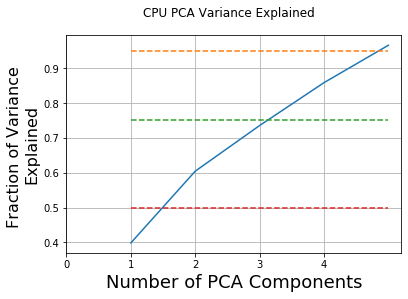

None

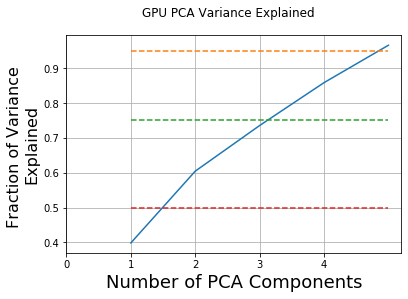

In [54]:
# Compare results ...

display(pca_scree(pca_loan_cpu.explained_variance_ratio_, "CPU"))
pca_scree(pca_loan_gpu.explained_variance_ratio_, "GPU")

In [56]:
# record PCA performance results
def pca_cpu() :    
    print("cpu pca")
    pca_loan_cpu = PCA_cpu(n_components=n_components)
    pca_loan_cpu.fit(loan_norm_pdf)


def pca_gpu() :
    pca_loan_gpu = PCA_gpu(n_components=n_components)
    pca_loan_gpu.fit(loan_norm_rdf)

    
#print(loan_norm_rdf.shape)    
run_times.add_result("pca", "gpu", time_command(pca_gpu, repeat=2))
run_times.add_result("pca", "cpu", time_command(pca_cpu, repeat=2))

run_times.display_results()

cpu pca
cpu pca
test                 CPU(s)               GPU(s)               GPU Speedup         
describe             4.9802               0.2724               18.29               
one_hot_encode       0.8645               0.0778               11.11               
filter_dt            0.6366               0.4096               1.55                
sorting              3.2606               0.2894               11.27               
histogram_ops        10.4541              0.1734               60.30               
groupby_ops          1.0373               0.3264               3.18                
join_ops             2.8766               0.3272               8.79                
pca                  11.8265              1.0467               11.30               


In [ ]:
#run_times.cpu_results

## Linear Regression (cuML / sklearn // snapML)

Linear regression is one of the most common algorithms applied to structured data.  Its useful when trying to make a prediction of a continuous variable.  For example, you could use linear regression to try and predict the total expected payment of a loan given historical data about default rates.  Lets try this below with our data set.  (Note lending club doesn't explicity provide this data in its data set, so we will use a fictitious total_payment column in our analysis)

In [57]:
# CPU / Sklearn
from sklearn.linear_model import LinearRegression as LRSKL
X = loan_norm_rdf.to_pandas()
y = loan_rdf['default'].to_pandas()    
lr_cpu = LRSKL(fit_intercept = True, normalize = False)
res_cpu = lr_cpu.fit(X,y)

In [58]:
# GPU / Rapids cuML example
from cuml.linear_model import LinearRegression as LRCUML
X = loan_norm_rdf
y2 = loan_rdf['default'].astype("float64")    
lr_gpu = LRCUML(fit_intercept = True, normalize = False) #, algorithm = "eig")
res_gpu = lr_gpu.fit(X,y2)


In [59]:
pgdf(y2)

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          0.0
21          0.0
22          0.0
23          0.0
24          0.0
25          0.0
26          0.0
27          0.0
28          0.0
29          0.0
30          0.0
31          0.0
32          0.0
33          0.0
34          0.0
35          0.0
36          0.0
37          0.0
38          0.0
39          0.0
40          0.0
41          0.0
42          0.0
43          0.0
44          0.0
45          0.0
46          0.0
47          0.0
48          0.0
49          0.0
50          0.0
51          0.0
52          0.0
53          0.0
54          0.0
55          0.0
56          0.0
57          0.0
58          0.0
59          0.0
60          0.0
61          0.0
62      

In [60]:
print(X.shape,y.shape)

(10224344, 8) (10224344,)


In [61]:
# Compare results
print("Coefficients:")
print(res_cpu.coef_)
print("intercept:")
print(res_cpu.intercept_)

print("Coefficients:")
print(res_gpu.coef_)
print("intercept:")
print(res_gpu.intercept_)


Coefficients:
[-0.02772356 -0.00233828  0.00210633 -0.01646674 -0.00090915  0.0566015
  0.00252775 -0.02424149]
intercept:
0.04722298076042822
Coefficients:
0     -0.027723557286354724
1     -0.002338280635054312
2     0.0021063291243203427
3      -0.01646674238652392
4    -0.0009091470428527487
5       0.05660150335661967
6     0.0025277533754742283
7     -0.024241493111330895
dtype: float64
intercept:
0.04722298076042807


In [62]:
#Record Results 

# CPU 
def lr_cpu() :
    lr_cpu = LRSKL(fit_intercept = True, normalize = False)
    res = lr_cpu.fit(X,y)
    
X = loan_norm_rdf.to_pandas()
y = loan_rdf['default'].to_pandas()    
run_times.add_result("linear_reg", "cpu", time_command(lr_cpu, repeat=5))


# GPU
def lr_gpu() :
    lr_gpu = LRCUML(fit_intercept = True, normalize = False, algorithm = "eig")
    res = lr_gpu.fit(X,y)

X = loan_norm_rdf
y = loan_rdf['default'].astype("float64")    
run_times.add_result("linear_reg", "gpu", time_command(lr_gpu, repeat=5))



run_times.display_results()    



test                 CPU(s)               GPU(s)               GPU Speedup         
describe             4.9802               0.2724               18.29               
one_hot_encode       0.8645               0.0778               11.11               
filter_dt            0.6366               0.4096               1.55                
sorting              3.2606               0.2894               11.27               
histogram_ops        10.4541              0.1734               60.30               
groupby_ops          1.0373               0.3264               3.18                
join_ops             2.8766               0.3272               8.79                
pca                  11.8265              1.0467               11.30               
linear_reg           3.2935               0.1445               22.79               


# Other interesting applications

## Dask With Rapids

In [ ]:
import os

import numpy as np
import pandas as pd
import cudf
import dask_cudf

np.random.seed(12)

#### Portions of this were borrowed and adapted from the
#### cuDF cheatsheet, existing cuDF documentation,
#### and 10 Minutes to Pandas.

## xgboost with Rapids

In [ ]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
import dask.array as da
import numpy as np
import xgboost as xgb
#import GPUtil
import time


# Define the function to be executed on each worker
def train(X, y, available_devices):
    dtrain = xgb.dask.create_worker_dmatrix(X, y)
    local_device = available_devices[xgb.rabit.get_rank()]
    # Specify the GPU algorithm and device for this worker
    params = {"tree_method": "gpu_hist", "gpu_id": local_device}
    print("Worker {} starting training on {} rows".format(xgb.rabit.get_rank(), dtrain.num_row()))
    start = time.time()
    xgb.train(params, dtrain, num_boost_round=500)
    end = time.time()
    print("Worker {} finished training in {:0.2f}s".format(xgb.rabit.get_rank(), end - start))


def main():
    max_devices = 16
    # Check which devices we have locally
    # available_devices = GPUtil.getAvailable(limit=max_devices)
    available_devices = [0,1]
    # Use one worker per device
    cluster = LocalCluster(n_workers=len(available_devices), threads_per_worker=4)
    client = Client(cluster)

    # Set up a relatively large regression problem
    n = 100
    m = 10000000
    partition_size = 100000
    X = da.random.random((m, n), partition_size)
    y = da.random.random(m, partition_size)

    xgb.dask.run(client, train, X, y, available_devices)

main()

## SnapML + Rapids

In [ ]:
### SnapML

X = loan_norm_rdfloan_rdf2.to_pandas()
y = loan_rdf['default'].to_pandas()

from pai4sk.linear_model import Ridge as LRSNAP
clf = LRSNAP(alpha=1.0)
clf.fit(X, y) # doctest: +NORMALIZE_WHITESPACE


#Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
#      normalize=False, random_state=None, solver='auto', tol=0.001)

# Summary

In [ ]:
#from cudf.core import DataFrame, Series



In [ ]:
print(df[["cats","dogs"]])
print(df.describe())

In [ ]:
print(uvals,labels)